In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [335]:
session = 'Mary-Anesthesia-20160809-01'
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)
variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [336]:
session_info['drugStart'][0]

1875.3599666666667

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Compute VAR(p)

In [127]:
def compute_VAR_p(window_data, p=1, unit_indices=None, PCA_dim=-1):
    if unit_indices is None:
        chunk = window_data
    else:
        chunk = window_data[:, unit_indices]

    results = {}
    results['explained_variance'] = None
    if PCA_dim > 0:
        if PCA_dim < 2:
            raise ValueError(f"PCA dimension must be greater than 1; provided value was {PCA_dim}")
        pca = PCA(n_components=PCA_dim)
        chunk = pca.fit_transform(chunk)
        results['explained_variance'] = pca.explained_variance_ratio_
    
    model = VAR(chunk)
    VAR_results = model.fit(p)

    results['coefs'] = VAR_results.coefs
    results['intercept'] = VAR_results.intercept

    N = chunk.shape[1]
    A_mat = np.zeros((N*p, N*p))
    for i in range(p):
        A_mat[0:N][:, i*N:(i+1)*N] = VAR_results.coefs[i]

    for i in range(p - 1):
        A_mat[(i + 1)*N:(i + 2)*N][:, i*N:(i + 1)*N] = np.eye(N)
    e = np.linalg.eigvals(A_mat)   
    results['eigs'] = e  
    results['criticality_inds'] = np.abs(e)

    try:
        results['info_criteria'] = VAR_results.info_criteria
    except:
        results['info_criteria'] = None

    return results

def predict_VAR_p(data, coefs, intercept, unit_indices=None):
    if unit_indices is None:
        chunk = data
    else:
        chunk = data[:, unit_indices]
    
    # BUILD PARAMS FOR PREDICTION
    p = coefs.shape[0]
    n = chunk.shape[1]
    
    params = np.zeros((1 + n*p, n))
    params[0] = intercept
    for i in range(p):
        params[1 + i*n:1 + (i + 1)*n] = coefs[i].T

    # LAG DATA
    lagged_data = np.zeros((chunk.shape[0] - p, chunk.shape[1]*p + 1))
    lagged_data[:, 0] = np.ones(lagged_data.shape[0])
    for i in range(p):
        lagged_data[:, i*chunk.shape[1] + 1:(i + 1)*chunk.shape[1] + 1] = chunk[p - 1 - i:chunk.shape[0] - 1 - i]
    
    # PREDICT
    prediction = lagged_data @ params
    true_vals = chunk[p:]
    
    return prediction, true_vals

In [153]:
# TODO: add access to lfpl, electrode_info
def windowed_VAR_p(window, window_ind, area, p=1, T_pred=25, stride=None):
    if stride is None:
        stride = window
        
    start_ind = window_ind*int(stride/dt)
    end_ind = window_ind*int(stride/dt) + int(window/dt)
    start_time = window_ind*stride
    end_time = window_ind*stride + window

    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    # COMPUTE VAR(p)
    window_data = lfp[start_ind:end_ind]
    results = compute_VAR_p(window_data, p, unit_indices)

    # PREDICT
    train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'], unit_indices)
    train_mse = ((train_prediction - train_true_vals)**2).mean()
    test_prediction, test_true_vals = predict_VAR_p(lfp[end_ind - p:end_ind + T_pred], results['coefs'], results['intercept'], unit_indices)
    test_mse = ((test_prediction - test_true_vals)**2).mean()
    persistence_baseline = ((lfp[end_ind:end_ind + T_pred] - lfp[end_ind - 1:end_ind + T_pred - 1])**2).mean()

    # ADD TO DICTIONARY
    results['train_mse'] = train_mse
    results['test_mse'] = test_mse
    results['persistence_baseline'] = persistence_baseline

    # ADD TIMESTAMPS
    results['start_ind'] = start_ind
    results['end_ind'] = end_ind
    results['start_time'] = start_time
    results['end_time'] = end_time

    # ADD PARAMETERS
    results['window'] = window
    results['stride'] = stride
    results['p'] = p
    results['T_pred'] = T_pred
    results['area'] = area
    
    return results

In [154]:
window = 10 # s
window_ind = 0
p = 10
T_pred = 25
area = 'vlPFC'

In [155]:
results = windowed_VAR_p(window, window_ind, area, p, T_pred)

In [330]:
data = load("/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR_p/grid_search/Mary-Anesthesia-20160809-01_May-12-2022_1504/all/pre/window_start_1781.0_end_1781.5")

In [334]:
pd.DataFrame([data])

,explained_variance,coefs,intercept,eigs,criticality_inds,info_criteria,train_mse,test_mse,persistence_baseline,start_ind,end_ind,start_time,end_time,window,stride,p,T_pred,area
0,None,"[[[0.5113868623495944, -0.14781588892151415, -...","[-0.110485386194906, -0.02405434112004965, 0.0...","[(-0.008653585056965257+0.9105269242055947j), ...","[0.9105680448146853, 0.9105680448146853, 0.755...",None,0.000002,0.001133,0.000043,1781000,1781500,1781.0,1781.5,0.5,0.5,1,25,all


# Test VAR on Random Windows From Each Section

In [167]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
    pre=(0, session_info['drugStart'][0]),
    induction=(session_info['drugStart'][0], eyes_close),
    during=(eyes_close, session_info['drugEnd'][1]),
    post=(session_info['drugEnd'][1], T)
)

In [307]:
section = 'pre'
area = 'vlPFC'
num_window_samples = 3
cutoff_percentile = 90
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
max_lag = 10

In [308]:
grid_search_df = []
lags = np.arange(1, max_lag + 1)
iterator = tqdm(total = len(windows)*len(lags)*num_window_samples)
for window in windows:
    for p in lags:
        # choose window inds to sample
        min_ind = int(section_times[section][0]/window)
        max_ind = int(section_times[section][1]/window)
        possible_inds = np.arange(min_ind, max_ind + 1)
        window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)

        for window_ind in window_inds:
            results = windowed_VAR_p(window, window_ind, area, p, T_pred)
            grid_search_df.append(results)
        
            iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/600 [00:00<?, ?it/s]

In [309]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

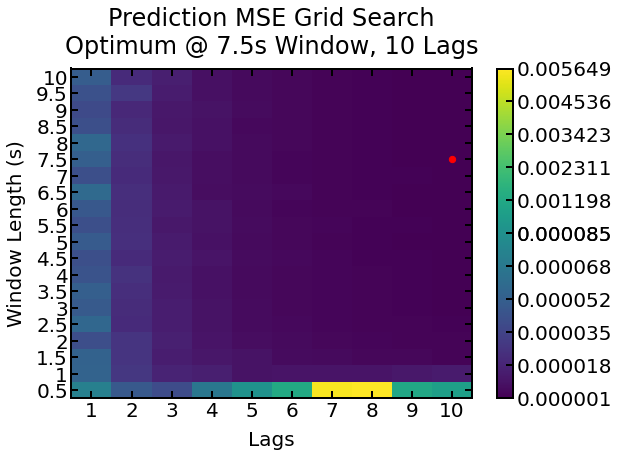

In [310]:
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
plt.pcolormesh(test_mse_mat, norm=norm)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [windows[i] for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar()
cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
cbar.set_ticks(cbar_ticks)
w_ind, p_ind = np.unravel_index(test_mse_mat.argmin(), test_mse_mat.shape)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags")
plt.show()

In [311]:
rows = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]
rows.train_mse.mean(), rows.test_mse.mean(), rows.persistence_baseline.mean()

(1.1499038099259673e-06, 1.2124676603491517e-06, 2.9145399621878106e-05)

In [312]:
# rows.criticality_inds.apply(lambda x: x.mean()).to_numpy()
rows.criticality_inds.apply(lambda x: x[x >= np.percentile(x, cutoff_percentile)].mean()).to_numpy()

array([0.95860989, 0.95793424, 0.95794702])

In [313]:
rows.criticality_inds.apply(lambda x: x[x >= np.percentile(x, cutoff_percentile)].mean()).to_numpy().mean()

0.9581637161935483

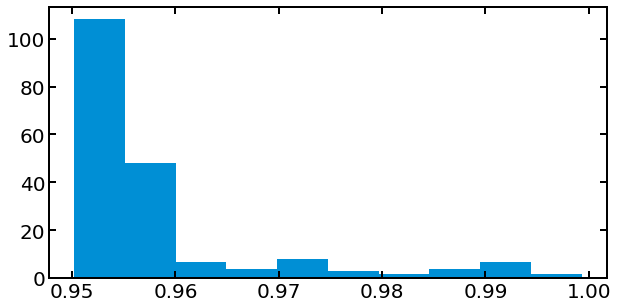

In [314]:
plt.hist(np.hstack(rows.criticality_inds.apply(lambda x: x[x >= np.percentile(x, cutoff_percentile)]).to_numpy()))
plt.show()

In [315]:
rows.criticality_inds.apply(lambda x: x.mean()).to_numpy()

array([0.91879713, 0.91883977, 0.91866748])

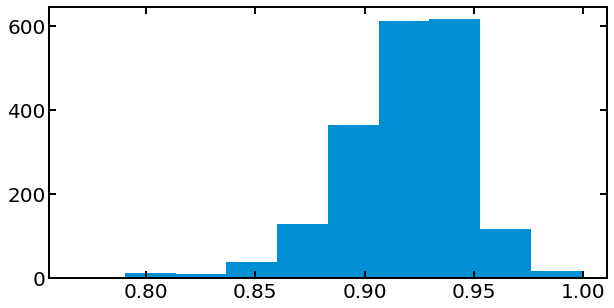

In [316]:
plt.hist(np.hstack(rows.criticality_inds.to_numpy()))
plt.show()

In [269]:
# X = np.tile(windows, (test_mse_mat.shape[1], 1)).T
# Y = np.tile(np.arange(1, max_lag+1), (test_mse_mat.shape[0], 1))
# Z = test_mse_mat
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X[5:], Y[5:], Z[5:])
# ax.set_xlabel("Window Length (s)")
# ax.set_ylabel("Lags")
# # ax.set_zlabel("Prediction MSE")
# plt.show()